In [1]:
import torch as tc
tc.set_default_tensor_type(tc.DoubleTensor)

In [2]:
from __future__ import division 
import sys, platform, os
sys.setrecursionlimit(4500) 

import numpy as np
import scipy as sp
from scipy.integrate import odeint, solve_bvp, solve_ivp

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
# K = 1

def TurningPoint(nu, l):
    return tc.arcsin(tc.sqrt(l*(l+1) / nu**2))

# Definitions for sink and tank functions

def sink(x):
    return tc.sin(x)

def tank(x):
    return tc.tan(x)

def dsink(x):
    return tc.cos(x)

def dtank(x):
    return 1 / tc.cos(x)**2

# Definitions for l=0 and l=1 modes

def Phi0nu(nu, x):
    return tc.sin(nu * x)/ nu / sink(x)

def Phi1nu(nu, x):
    return Phi0nu(nu, x) * (1 / tank(x) - nu / tc.tan(nu * x)) / tc.sqrt(nu**2 - 1)

def dPhi0nu(nu, x):
    return (nu * tc.cos(nu * x) * sink(x) - tc.sin(nu * x) * dsink(x)) / nu / sink(x)**2

def dPhiByPhi_recurrence(nu, l, ratio, x):
    return l / tank(x) + tc.sqrt(nu**2 - (l+1)**2) * ratio


# Recurrence coefficients

def alphal(nu, l, x):
    return (2*l + 1) / tank(x) / tc.sqrt(nu**2 - (l+1)**2)

def betal(nu, l):
    return -tc.sqrt(nu**2 - l**2) / tc.sqrt(nu**2 - (l+1)**2)

def ratio_list(nu_int, x):
    '''
        ratio_l := -y_{l+1} / y_l = beta_{l+1}/(alpha_{l+1} + ...)
                0<=l<=nu-1
        ratio_{nu - 1} = 0
        ratio_{nu - 2} = -y_{nu-1} / y_{nu-2} 
                        = limit_{l->nu-1} (beta_l / alpha_l)
    '''

    res = tc.zeros([nu_int, len(x)])
    nu = tc.tensor(nu_int, dtype=tc.float64)
    
    res[-1] = 0
    res[-2] = - tank(x) / tc.sqrt(2*nu - 1)
    llist = tc.arange(nu_int - 3, 0, -1)
    for li in llist:
        res[li] = betal(nu, li + 1) / (alphal(nu, li + 1, x) + res[li+1])

    return res

def ratio_list_modified(nu_int, lmax, x):
    '''
        ratio_l := -y_{l+1} / y_l = beta_{l+1}/(alpha_{l+1} + ...)
                0<=l<=lmax-1<=nu-1
        ratio_{nu - 1} = 0
        ratio_{nu - 2} = -y_{nu-1} / y_{nu-2} 
                        = limit_{l->nu-1} (beta_l / alpha_l)
    '''
    if nu_int <= lmax: 
        res = tc.zeros([nu_int, len(x)])
        nu = tc.tensor(nu_int, dtype=tc.float64)
        
        res[-1] = 0
        res[-2] = - tank(x) / tc.sqrt(2*nu - 1)
        llist = tc.arange(nu_int - 3, 0, -1)
        for li in llist:
            res[li] = betal(nu, li + 1) / (alphal(nu, li + 1, x) + res[li+1])
        
    else:
        res = tc.zeros([lmax, len(x)])
        nu = tc.tensor(nu_int, dtype=tc.float64)
        
        temp = - tank(x) / tc.sqrt(2*nu - 1)
        for ll in tc.arange(nu_int - 3, lmax -2, -1):
            temp = betal(nu, ll + 1) / (alphal(nu, ll + 1, x) + temp)
        
        res[-1] = temp # which corresponds to y_{lmax}/y_{lmax-1}
        llist = tc.arange(lmax - 2, 0, -1)
        for li in llist:
            res[li] = betal(nu, li + 1) / (alphal(nu, li + 1, x) + res[li+1])

    return res

# Computation

def Pure_forward_recurrence(nu_int, x):
    '''
        Input:  nu          int
                x           (N) torch tensor

        Output: Phi_l^nu    (nu * N) torch tensor with 0<=l<=nu-1
    '''

    phi = tc.zeros([nu_int, len(x)])
    nu = tc.tensor(nu_int, dtype=tc.float64)

    phi[0] = Phi0nu(nu, x)
    phi[1] = Phi1nu(nu, x)

    llist = tc.arange(2, nu_int)

    for li in llist:
        phi[li] = alphal(nu, li-1, x) * phi[li-1] + betal(nu, li-1) * phi[li-2]

    return phi

def Pure_backward_recurrence(nu_int, x):
    '''
        Input:  nu          int
                x           (N) torch tensor

        Output: Phi_l^nu    (nu * N) torch tensor with 0<=l<=nu-1
    '''
    
    phi = tc.zeros([nu_int, len(x)])
    nu = tc.tensor(nu_int, dtype=tc.float64)

    phi[0] = Phi0nu(nu, x)
    phi[1] = Phi1nu(nu, x)

    llist = tc.arange(2, nu_int)
    rlist = ratio_list(nu_int, x)

    for li in llist:
        phi[li] = -rlist[li - 1] * phi[li - 1]

    return phi

def Recurrence(nu_int, x, lmax = False):
    '''
        Input:  nu          int
                x           (N) torch tensor

        Output: Phi_l^nu    (lmax * N) torch tensor with 0<=l<=nu-1
    '''
    if lmax == False:
        lmax = nu_int

    phi = tc.zeros([lmax, len(x)])
    dphi = tc.zeros([lmax, len(x)])
    nu = tc.tensor(nu_int, dtype=tc.float64)

    phi[0] = Phi0nu(nu, x)
    phi[1] = Phi1nu(nu, x)

    llist = tc.arange(2, min(nu_int,lmax))
    # rlist = ratio_list(nu_int, x)
    rlist = ratio_list_modified(nu_int, lmax, x)


    dphi[0] = dPhi0nu(nu, x)
    dphi[1] = dPhiByPhi_recurrence(nu, 1, rlist[0], x) * phi[1]

    for li in llist:
        phi[li] = tc.where(x > TurningPoint(nu_int, li),  # turning point condition
                            alphal(nu, li-1, x) * phi[li-1] + betal(nu, li-1) * phi[li-2],  # forward recurrence
                            -rlist[li - 1] * phi[li - 1]) # backward recurrence
        
        dphi[li] = dPhiByPhi_recurrence(nu, li, rlist[li], x) * phi[li]

    return phi, dphi

In [50]:
xstart = 5e-8
xend = 7.5e-1

n1 = 100
n2 = 1000
n3 = 10000

testx1 = tc.linspace(xstart, xend, n1*2)
testx2 = tc.linspace(xstart, xend, n2*2)
testx3 = tc.linspace(xstart, xend, n3*2)


res1_Phi, res1_dPhi = Recurrence(n1, testx1, lmax = 4000)
res2_Phi, res2_dPhi = Recurrence(n2, testx2, lmax = 4000)
res3_Phi, res3_dPhi = Recurrence(n3, testx3, lmax = 4000)

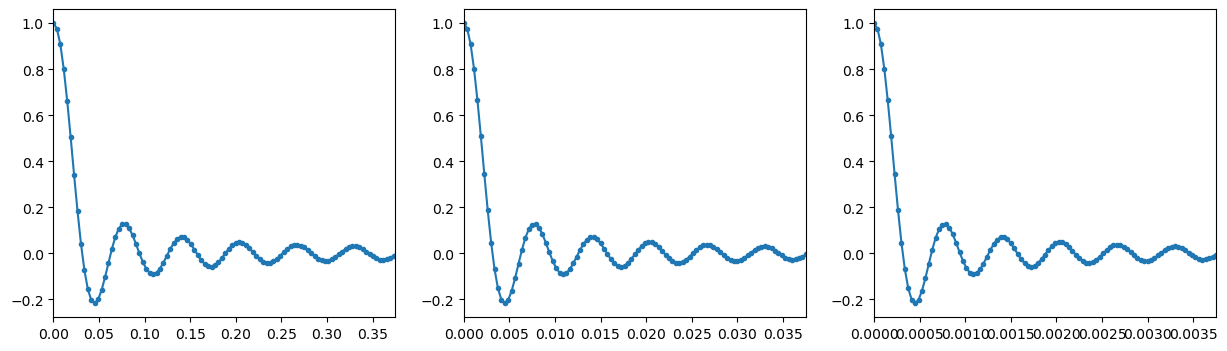

In [51]:
figs = plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(testx1, res1_Phi[0], '.-')
plt.xlim([0, xend * 50 / n1])

plt.subplot(132)
plt.plot(testx2, res2_Phi[0], '.-')
plt.xlim([0, xend * 50 / n2])

plt.subplot(133)
plt.plot(testx3, res3_Phi[0], '.-')
plt.xlim([0, xend * 50 / n3])

plt.show()

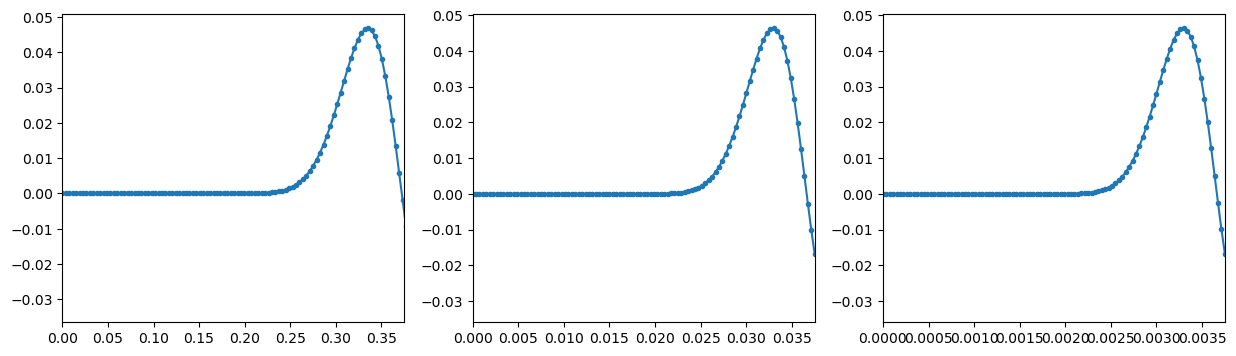

In [52]:
lindex = 30

figs = plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(testx1, res1_Phi[lindex], '.-')
plt.xlim([0, xend * 50 / n1])

plt.subplot(132)
plt.plot(testx2, res2_Phi[lindex], '.-')
plt.xlim([0, xend * 50 / n2])

plt.subplot(133)
plt.plot(testx3, res3_Phi[lindex], '.-')
plt.xlim([0, xend * 50 / n3])

plt.show()

In [4]:
testnu = 2000
xstart = 5e-8
xend = 7.3e-1
bins = 10000
testx = tc.linspace(xstart, xend, bins)

# testx.to('cuda')

res1_Phi, res1_dPhi = Recurrence(testnu, testx, lmax = 500) #, res_dPhi 
res2_Phi, res2_dPhi = Recurrence(testnu, testx, lmax = 3000) #, res_dPhi 

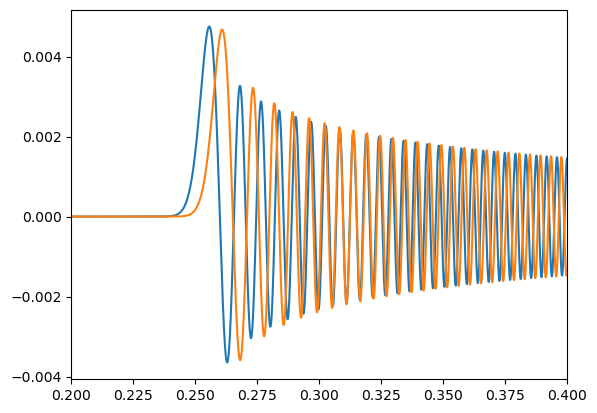

In [5]:
testli = 499
plt.plot(testx, res1_Phi[testli]) 
plt.plot(testx, res2_Phi[testli + 10]) 

plt.xlim([0.2, 0.4])
# plt.ylim([-0.3,1.1])

plt.show()

In [32]:
test1 = ratio_list(2000, testx)
test2 = ratio_list_modified(2000, 500, testx)

In [18]:
# large l test
# for OmegaK = -0.05, h = 0.675, 
# we have sqrt(K)*eta0 <=0.73


testnu = 50000
xstart = 5e-8
xend = 5e-2
bins = 10000
testx = tc.linspace(xstart, xend, bins)

# testx.to('cuda')

res_Phi, res_dPhi = Recurrence(testnu, testx, lmax = 4000) #, res_dPhi 

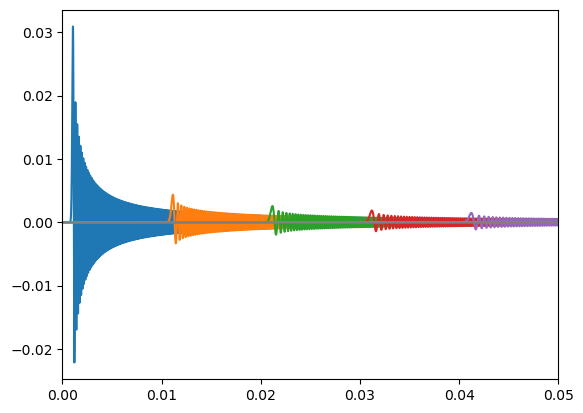

In [22]:
for li in np.arange(50, 4000, 500):
    plt.plot(testx, res_Phi[li]) 

plt.xlim([0, xend])
# plt.ylim([-0.3,1.1])

plt.show()

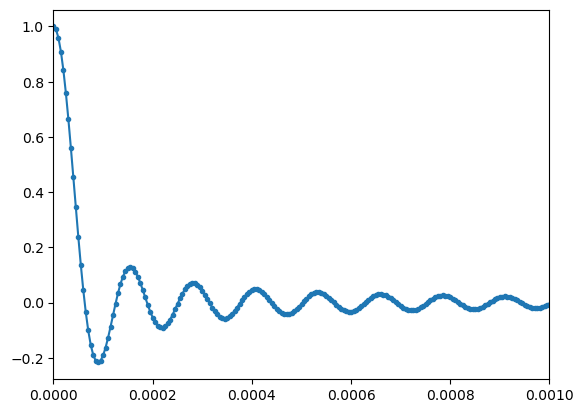

In [20]:
# for li in np.arange(50, 2500, 400):
#     plt.plot(testx, res_dPhi[li]) 
index = 0

# fig = plt.figure(figsize=(16,4))
# plt.subplot(121)
plt.plot(testx, res_Phi[index], '.-') 
plt.xlim([0, 0.001])
# plt.subplot(122)
# plt.plot(testx, res_dPhi[index], '.-') 
# plt.xlim([0, 0.03])
# plt.xlim([0.3, 0.35])
# plt.ylim([-10,10])

plt.show()

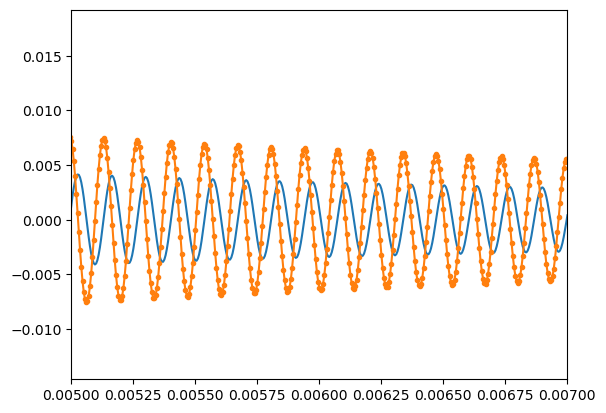

In [27]:
index = 100

plt.plot(testx, res_Phi[index], '-') 
plt.plot(testx, res_dPhi[index]/testnu * 2, '.-')

plt.xlim([0.005, 0.007])
# plt.xlim([0.25, 0.3])
# plt.xlim([0.3, 0.35])
# plt.ylim([-10,10])

plt.show()

In [15]:
# small l test

testnu = 21
testx = tc.arange(0.001, tc.pi/2, 0.001)

res1 = Recurrence(testnu, testx)

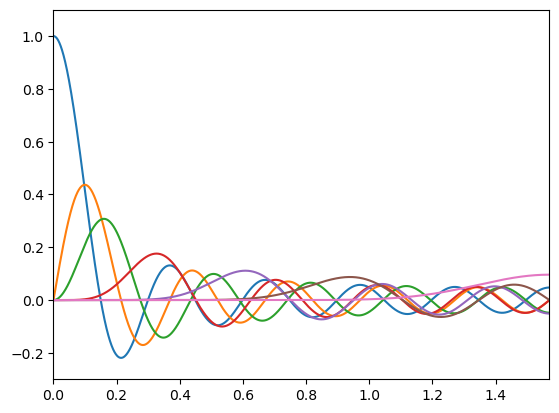

In [17]:
for li in np.array([0, 1, 2, 5, 10, 15, 20]):
    plt.plot(testx, res1[li]) 

plt.xlim([0, tc.pi / 2])
plt.ylim([-0.3,1.1])

plt.show()

In [47]:
# large l test
# for OmegaK = -0.05, h = 0.675, 
# we have sqrt(K)*eta0 <=0.73

testnu = 3001
deltax = 1e-4
xend = 0.73
testx = tc.arange(deltax, xend, deltax)

res2 = Recurrence(testnu, testx)

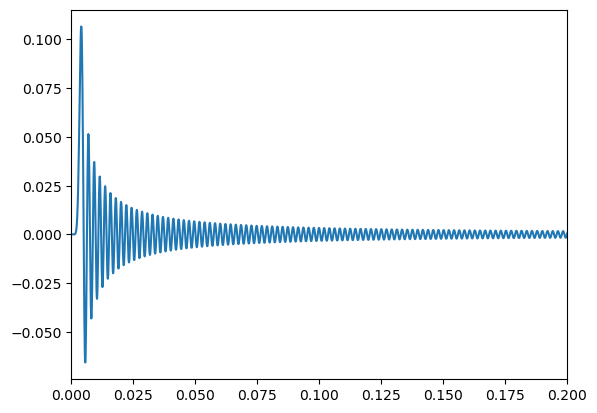

In [66]:
plt.plot(testx, res2[10]) 

plt.xlim([0., 0.2])
# plt.ylim([-0.003,0.003])

plt.show()

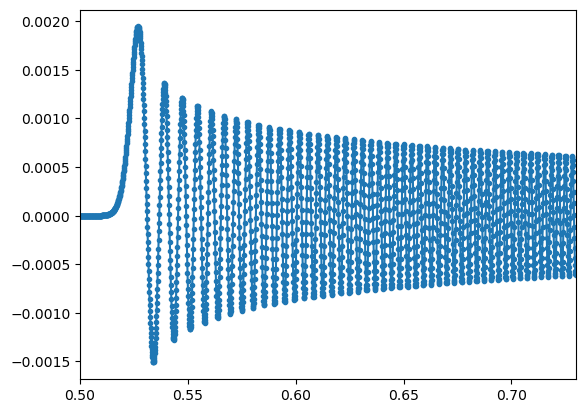

In [68]:
plt.plot(testx, res2[1500], '.-') 

plt.xlim([0.5, xend])
# plt.ylim([-0.3,1.1])

plt.show()

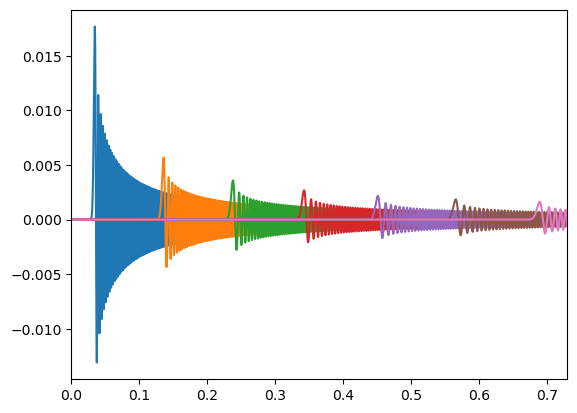

In [56]:
for li in np.arange(100, 2100, 300):
    plt.plot(testx, res2[li]) 

plt.xlim([0, xend])
# plt.ylim([-0.3,1.1])

plt.show()

In [21]:
# large l test
# for OmegaK = -0.05, h = 0.675, 
# we have sqrt(K)*eta0 <=0.73

testnu = 50000
deltax = 2e-5
xend = 0.73
testx = tc.arange(deltax, xend, deltax)

res3 = Recurrence(testnu, testx, lmax=4000)

 l = tensor(3999)ensor(935)tensor(1365)tensor(2939)tensor(3056)tensor(3153)
Done!


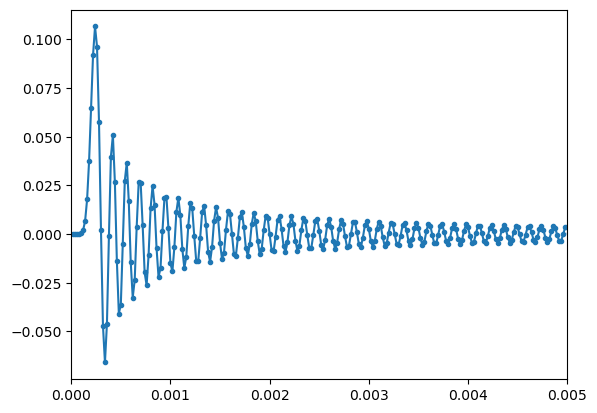

In [26]:
# for li in np.arange(100, 25000, 2000):
#     plt.plot(testx, res3[li]) 
    
plt.plot(testx, res3[10], '.-')

plt.xlim([0, 0.005])
# plt.ylim([-0.3,1.1])

plt.show()

In [ ]:
## other tests

In [107]:
testnu = 21
testx = tc.arange(0.001, tc.pi/2, 0.001)

res1 = Pure_forward_recurrence(testnu, testx)
res2 = Pure_backward_recurrence(testnu, testx)

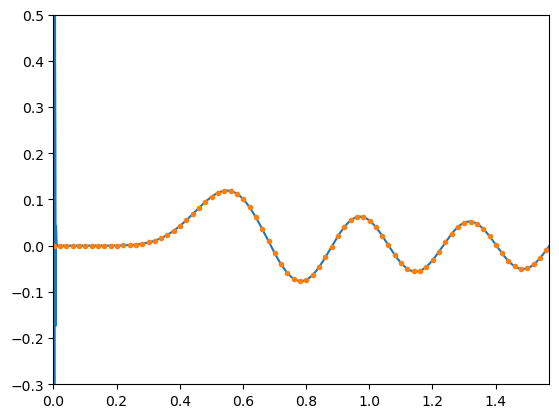

In [150]:
ltest = 9

plt.plot(testx, res1[ltest]) 
plt.plot(testx[::20], res2[ltest, ::20], '.')

# plt.xlim([TurningPoint(tc.tensor([21.]), tc.tensor([ltest])), tc.pi / 2])
plt.xlim([0, tc.pi / 2])
plt.ylim([-0.3,0.5])

plt.show()

In [162]:
testnu = 21
testx = tc.arange(0.001, tc.pi/2, 0.001)

res = Recurrence(testnu, testx)

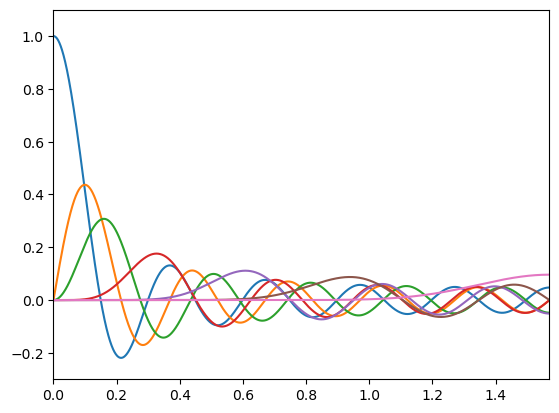

In [167]:

for li in np.array([0, 1, 2, 5, 10, 15, 20]):
    plt.plot(testx, res[li]) 

plt.xlim([0, tc.pi / 2])
plt.ylim([-0.3,1.1])

plt.show()